In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import jax

os.listdir()
os.chdir('..')
from src.c3po.model.model import C3PO
from src.c3po.toy_model_generators.hmm import generate_hmm_spike_train


# Simulated Data

In [4]:
t = np.arange(0, 3000)
mark_ids, mark_times, marks, template_waveforms, firing_rates, hmm_sequence = (
    generate_hmm_spike_train(
        t=t,
        noise_scale=0.1,
        peak_rng=(0.3, 1),
        soft_binarize_firing_rate=True,
        n_units=30,
    )
)


relative_rates = firing_rates[:, 0] / firing_rates[:, 1]
ind_sort = np.argsort(relative_rates)

# Train

### Define Model and Training Data

In [25]:
# prep data for model
from src.c3po.model.util import prep_training_data
delta_t = np.diff(mark_times)[None, ...]
x = marks[1:][None, ...]

sample_length = 2000
x_train, delta_t_train = prep_training_data(x, delta_t, sample_length)
i = sample_length

# hyperparams
latent_dim = 4
context_dim = 2
encoder_widths = [32, 16, 8]
context_widths = [32, 16, 8]
n_neg_samples = 15
encoder_args = dict(encoder_model="simple",
                    widths = encoder_widths)
context_args = dict(context_model="simpleRNN",
                    widths = context_widths)
rate_args = dict(rate_model="bilinear",)


model = C3PO(encoder_args, context_args, rate_args, latent_dim, context_dim, n_neg_samples)

rand_key = jax.random.PRNGKey(0)
params = model.init(jax.random.PRNGKey(0), x, delta_t, rand_key)
run_model = jax.jit(model.apply)
x_train.shape

3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
(1, 44862, 4) (1, 44861)
neg_z (1, 15, 44862, 4)
c (1, 44862, 2)
neg_rates (1, 15, 44861)


(43, 2000, 32)

### Run optimization

In [26]:
import optax
from src.c3po.model.model import loss
learning_rate = 1e-4
batch_size = 8


def training_loss_fun(params, x, delta_t, rand_key):
    pos_rates, cum_neg_rates = run_model(params, x, delta_t, rand_key)
    return loss(pos_rates, cum_neg_rates, delta_t)
loss_grad_fn = jax.value_and_grad(training_loss_fun)



optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate),
)

# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)
# Run training loop.
tracked_loss = []
for i in range(1000):
    ind = np.arange(x_train.shape[0])
    np.random.shuffle(ind)
    epoch_loss = []
    j = 0
    while j < x_train.shape[0]:
        # Perform one gradient update.
        rand_key, _ = jax.random.split(rand_key)
        batch_inds = ind[j : j + batch_size]
        loss_val, grads = loss_grad_fn(
            params, x_train[batch_inds], delta_t_train[batch_inds], rand_key
        )
        epoch_loss.append(loss_val)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        j += batch_size
    tracked_loss.append(np.mean(epoch_loss))
    if i % 2 == 0:
        print(f"Loss step {i}: ", loss_val)

(8, 2000, 4) (8, 1999)
neg_z (8, 15, 2000, 4)
c (8, 2000, 2)
neg_rates (8, 15, 1999)
(3, 2000, 4) (3, 1999)
neg_z (3, 15, 2000, 4)
c (3, 2000, 2)
neg_rates (3, 15, 1999)
Loss step 0:  25.623297
Loss step 2:  10.740562
Loss step 4:  6.2672176
Loss step 6:  4.7204413
Loss step 8:  3.6997511
Loss step 10:  3.1588655
Loss step 12:  2.7437744
Loss step 14:  2.3655846
Loss step 16:  2.0404396
Loss step 18:  1.7648298
Loss step 20:  1.6021638
Loss step 22:  1.4411057
Loss step 24:  1.3415178
Loss step 26:  1.2488027
Loss step 28:  1.2083083
Loss step 30:  1.1929277
Loss step 32:  1.1406802
Loss step 34:  1.1140012
Loss step 36:  1.0877768
Loss step 38:  1.0659785
Loss step 40:  1.0840453
Loss step 42:  1.092109
Loss step 44:  1.0321362
Loss step 46:  1.0810875
Loss step 48:  1.0847498
Loss step 50:  1.0985965
Loss step 52:  1.0804123
Loss step 54:  1.0377716
Loss step 56:  1.0676004
Loss step 58:  1.0524361
Loss step 60:  1.065042
Loss step 62:  1.0601885
Loss step 64:  1.0621163
Loss step 66

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

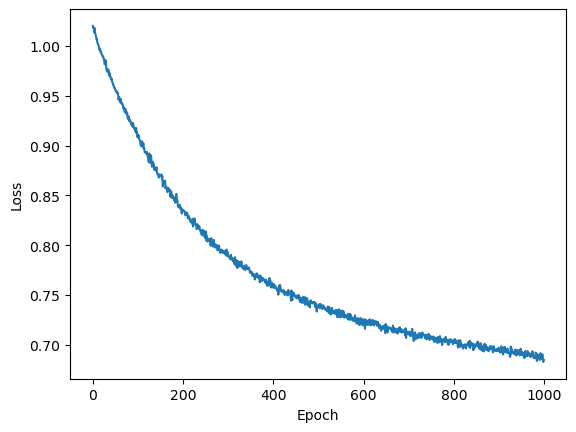

In [17]:
epoch = np.arange(len(tracked_loss))
plt.plot(epoch, tracked_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Generate and Look at results

In [18]:
pos_rates, cum_neg_rates = run_model(params, x_train, delta_t_train, rand_key)
pos_rates  # .shape

Array([[3.2451062 , 3.2581797 , 3.2406073 , ..., 1.5121522 , 1.7373596 ,
        1.9055479 ],
       [1.2851325 , 1.6457465 , 1.9155453 , ..., 1.2759645 , 1.1395456 ,
        1.9933501 ],
       [1.7357742 , 2.498007  , 1.9761039 , ..., 2.377194  , 2.4999576 ,
        1.8874891 ],
       ...,
       [1.2996613 , 1.1806201 , 1.7406318 , ..., 1.4464675 , 1.9661125 ,
        2.4342437 ],
       [1.2692887 , 1.5603727 , 1.5075289 , ..., 0.70401984, 1.0172055 ,
        2.0724387 ],
       [0.98534805, 1.3985353 , 1.7181742 , ..., 1.747895  , 1.2830768 ,
        1.534813  ]], dtype=float32)

In [19]:
from src.c3po.model.model import Embedding

embedding_params = {
    "params": params["params"]["embedding"],
    "state": params["state"]["embedding"],
}

z, c = Embedding(encoder_args, context_args, latent_dim, context_dim).apply(
    embedding_params, x, delta_t
)


c = np.array(c)

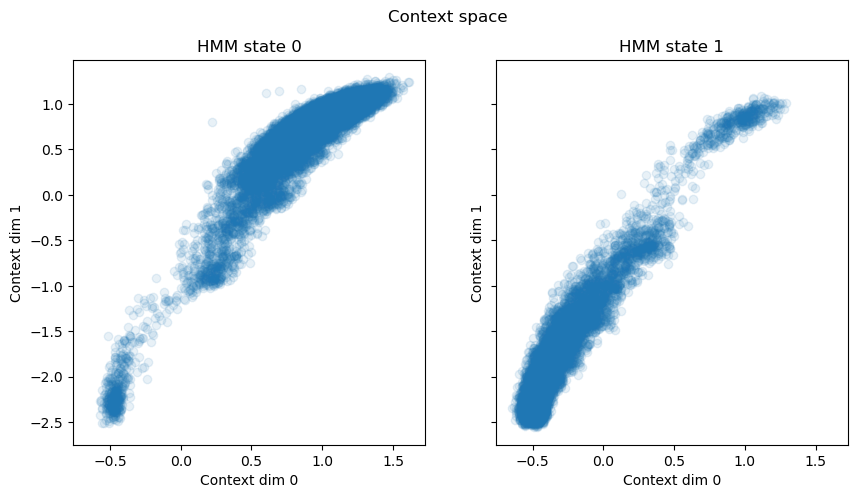

In [20]:
mark_ind = np.digitize(mark_times[1:], t)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
include = hmm_sequence[mark_ind, 0].astype(bool)
ax[0].scatter(c[0, include, 0], c[0, include, 1], alpha=0.1)
ax[1].scatter(c[0, ~include, 0], c[0, ~include, 1], alpha=0.1)

fig.suptitle("Context space")
ax[0].set_title("HMM state 0")
ax[1].set_title("HMM state 1")

for a in ax:
    a.set_xlabel("Context dim 0")
    a.set_ylabel("Context dim 1")

Text(0.5, 0, 'Time (s)')

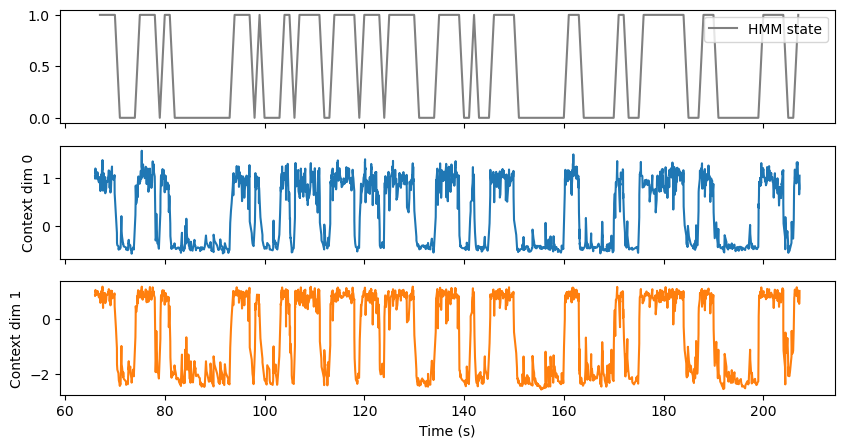

In [21]:
plot_slice = slice(1000, 3000)
fig, ax = plt.subplots(nrows=context_dim + 1, figsize=(10, 5), sharex=True)

for i, a in enumerate(ax[1:]):
    # a.scatter(mark_times[plot_slice],c[0, plot_slice, i],s=50,alpha=.7)
    a.plot(mark_times[plot_slice], c[0, plot_slice, i], c=plt.cm.tab10(i))
    t_max = mark_times[plot_slice].max()
    # ind_plot = np.where(t < t_max)[0][-1]
    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = prop_cycle.by_key()["color"]
    a.set_ylabel(f"Context dim {i}")
ind_plot = np.logical_and(t < t_max, t > mark_times[plot_slice].min())
ax[0].plot(t[ind_plot], hmm_sequence[ind_plot, 0], label="HMM state", c="grey")
ax[0].legend(loc="upper right")
ax[-1].set_xlabel("Time (s)")

# fig, ax = plt.subplots(nrows=context_dim, figsize=(10, 5), sharex=True)
# for i,a in enumerate(ax):
#     a.plot(c[0, plot_slice, i])
#     # a.plot(hmm_sequence[mark_ind, 0][plot_slice], zorder=-1,label="HMM state")
#     # t_max = mark_times[plot_slice].max()
#     # ind_plot = np.where(t < t_max)[0][-1]
#     a.plot(hmm_sequence[:ind_plot, 0][plot_slice], label="HMM state")
#     a.set_ylabel(f"Context dim {i}")
# ax[0].legend(loc="upper right")

In [14]:
relative_rates = firing_rates[:, 0] / firing_rates[:, 1]
relative_rates = np.log10(relative_rates)
relative_rates

rate_color = np.clip(
    (relative_rates - relative_rates.min())
    / (relative_rates.max() - relative_rates.min()),
    0,
    1,
)
rate_color = plt.cm.PRGn(rate_color)

Text(0.5, 1.0, 'HMM state 1')

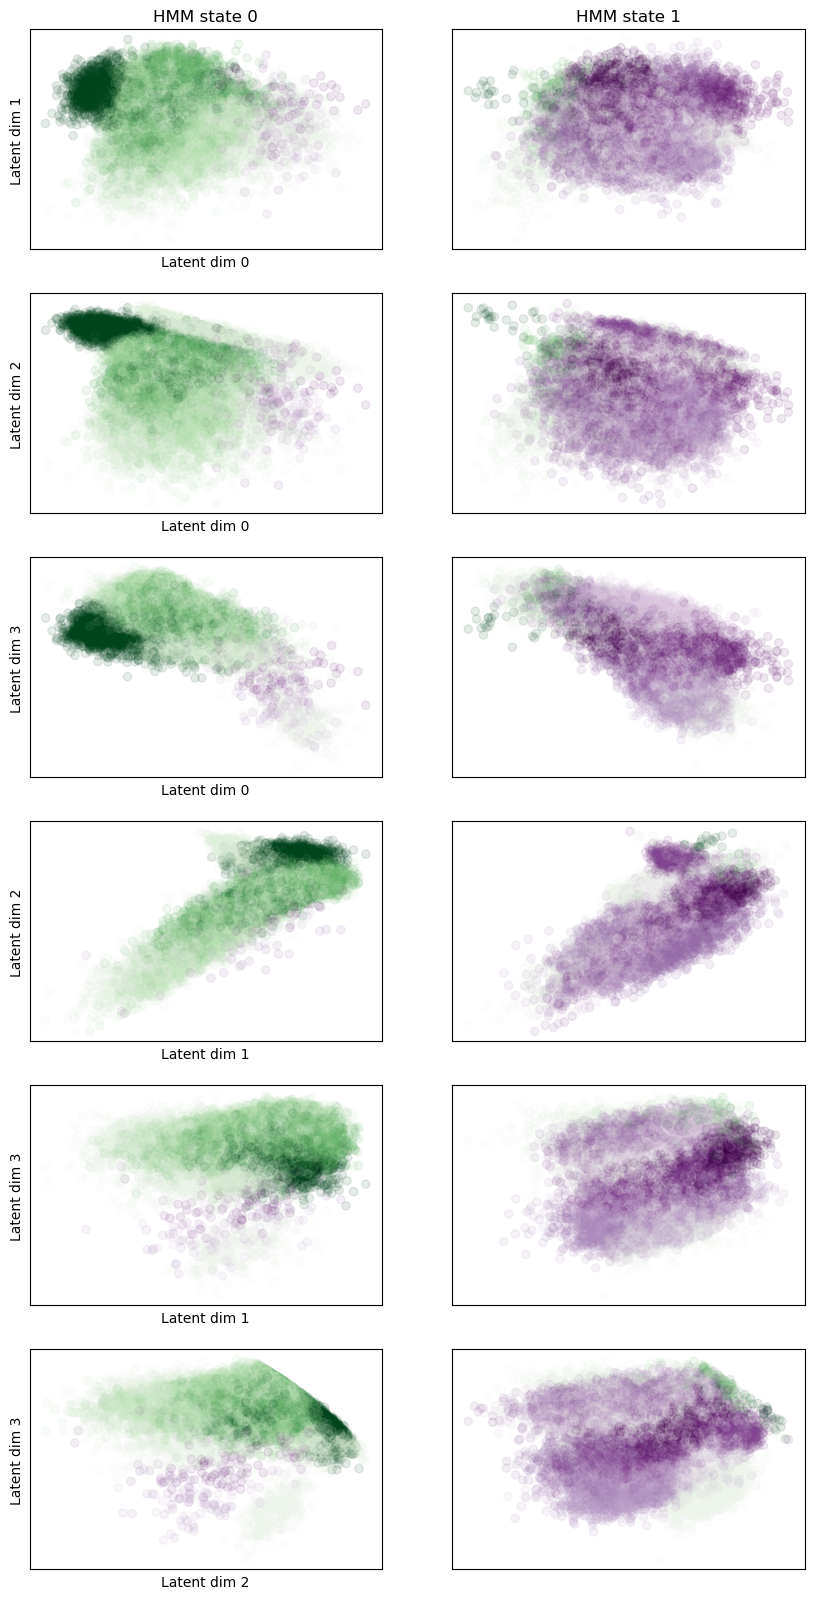

In [15]:
import math

mark_ind = np.digitize(mark_times[1:], t)

fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(10, 20))
include = hmm_sequence[mark_ind, 0].astype(bool)

ax_loc = 0
for i in range(latent_dim):
    for j in range(i + 1, latent_dim):
        ax[ax_loc, 0].scatter(
            z[0, include, i],
            z[0, include, j],
            alpha=0.1,
            #  c=plt.cm.jet(mark_ids[1:][include]/mark_ids.max()),
            c=rate_color[mark_ids[1:][include]],
        )
        ax[ax_loc, 1].scatter(
            z[0, ~include, i],
            z[0, ~include, j],
            alpha=0.1,
            # c=plt.cm.jet(mark_ids[1:][~include] / mark_ids.max()),
            c=rate_color[mark_ids[1:][~include]],
        )
        ax[ax_loc, 0].set_xlabel(f"Latent dim {i}")
        ax[ax_loc, 0].set_ylabel(f"Latent dim {j}")
        ax_loc += 1

    # break

for a in np.ravel(ax):
    a.set_xticks([])
    a.set_yticks([])
ax[0, 0].set_title("HMM state 0")
ax[0, 1].set_title("HMM state 1")
# ax[0,0].scatter(z[0, include, 1], z[0, include, 2], alpha=0.1)
# ax[0,1].scatter(z[0, ~include, 1], z[0, ~include, 2], alpha=0.1)

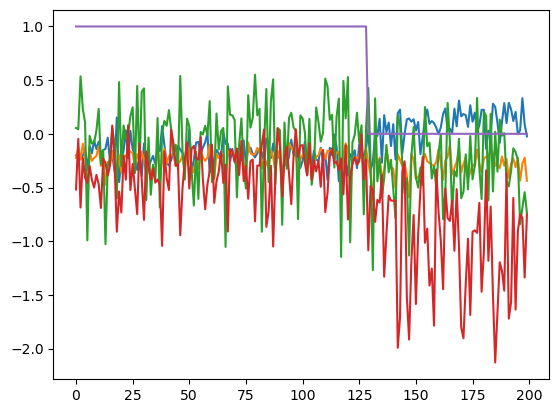

In [16]:
# fig, ax = plt.subplots(nrows=latent_dim, figsize=(10, 5), sharex=True)

plot_slice = slice(0, 200)
# for i,a in enumerate(ax):
#     a.scatter(mark_times[plot_slice],z[0, plot_slice, i],s=30)
#     t_max = mark_times[plot_slice].max()
#     ind_plot = np.where(t < t_max)[0][-1]
#     prop_cycle = plt.rcParams['axes.prop_cycle']
#     colors = prop_cycle.by_key()['color']
#     a.plot(t[:ind_plot], hmm_sequence[:ind_plot, 0], label="HMM state",c=colors[1])
#     a.set_ylabel(f"Latent dim {i}")


plt.plot(z[0, plot_slice, :])
plt.plot(hmm_sequence[mark_ind, 0][plot_slice])

In [14]:
from spyglass.common import sgc

[2024-08-11 10:50:05,524][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-08-11 10:50:05,570][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


ImportError: cannot import name 'sgc' from 'spyglass.common' (/home/sambray/Documents/spyglass/src/spyglass/common/__init__.py)

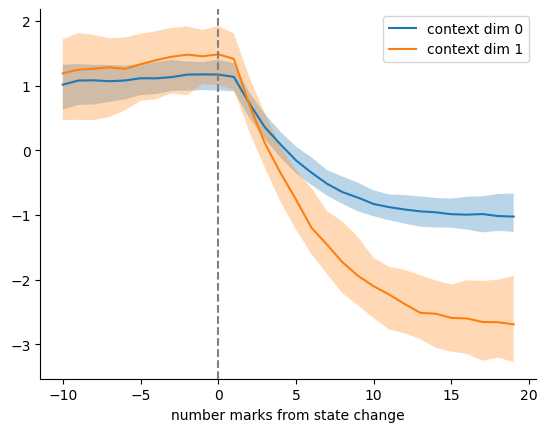

In [18]:
mark_ind = np.digitize(mark_times[1:], t)

# fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
fig = plt.figure()
ax = fig.gca()

ax.spines[["top", "right"]].set_visible(False)
mark_state = hmm_sequence[mark_ind, 0]  # .astype(bool)

enter = np.where(np.diff(mark_state) == -1)[0]

val = []
for i in enter:
    val.append(c[0, i - 10 : i + 20, :])

val = np.array(val)
xx = np.arange(val.shape[1]) - 10
for i in range(val.shape[-1]):
    plt.plot(xx, np.median(val[:, :, i], axis=0), label=f"context dim {i}")
    plt.fill_between(
        xx,
        np.percentile(val[:, :, i], 25, axis=0),
        np.percentile(val[:, :, i], 75, axis=0),
        alpha=0.3,
    )

plt.axvline(0, c="grey", ls="--")

plt.xlabel("number marks from state change")
plt.legend()

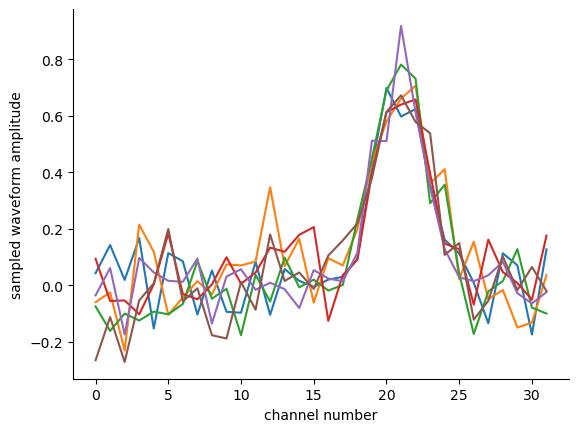

In [19]:
loc = np.where(mark_ids == 1)[0]
fig = plt.figure()
ax = fig.gca()
marks[loc].shape

plt.plot(marks[loc][:6].T)
plt.xlabel("channel number")
plt.ylabel("sampled waveform amplitude")
ax.spines[["top", "right"]].set_visible(False)